In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import gc
import shutil
import calmap
from operator import itemgetter
# 需要改为你的root
root_path = '/high_perf_store3/data-lm/xiezixun/futures_predict'
data_path = os.path.join(root_path, 'data/赛题数据发布/赛道一/交易数据/赛道一_Brent交易数据.csv')

# 设置完整显示所有行列
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
    
df = pd.read_csv(data_path, low_memory=False)
df.shape

(22498, 10)

In [2]:
df.columns

Index(['ID', '证券代码', '日期', '开盘价', '最高价', '最低价', '收盘价', '结算价', '成交量', '持仓量'], dtype='object')

In [3]:
df.head()

,ID,证券代码,日期,开盘价,最高价,最低价,收盘价,结算价,成交量,持仓量
0,1,B.IPE,2019/1/2,0.00,56.56,52.51,54.68,54.91,300950.0,492814
1,2,B.IPE,2019/1/3,54.29,56.30,53.93,55.55,55.95,278356.0,499715
2,3,B.IPE,2019/1/4,55.67,58.31,55.34,57.42,57.06,321106.0,501313
3,4,B.IPE,2019/1/7,57.41,58.93,57.26,57.57,57.33,296583.0,495064
4,5,B.IPE,2019/1/8,57.64,58.87,57.13,58.59,58.72,288249.0,488207


## NAN Search

In [4]:
nans_df = df.isna()
nans_groups={}
for col in df.columns:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()
nans_groups = sorted(nans_groups.items(), key=itemgetter(0), reverse=True)
for k,v in nans_groups:
    print(f'{v}: NAN count = {k}, share = {round(k / len(df) * 100, 2)}%')

['最高价']: NAN count = 1248, share = 5.55%
['最低价']: NAN count = 1247, share = 5.54%
['开盘价']: NAN count = 1190, share = 5.29%
['收盘价']: NAN count = 1021, share = 4.54%
['成交量']: NAN count = 186, share = 0.83%
['ID', '证券代码', '日期', '结算价', '持仓量']: NAN count = 0, share = 0.0%


# 离散值 & 连续值EDA

In [5]:
def summarize_df(df, nunique_threshold=100):
    """
    nunique_threshold : 一个数值型特征如果其唯一值数量低于此阈值，将被当作离散变量处理。
    """
    # 1. 连续变量分析
    # -------------------
    # 选择数值类型且唯一值数量 > nunique_threshold 的列
    continuous_cols = [
        col for col in df.columns 
        if pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() > nunique_threshold
    ]
    
    if continuous_cols:
        print("\n--- 1. 连续变量统计摘要 ---\n")
        
        # 使用describe高效计算基础统计量
        summary_conti = df[continuous_cols].describe().T
        
        # 添加更多有用的统计信息
        summary_conti['var'] = df[continuous_cols].var()
        summary_conti['skew'] = df[continuous_cols].skew()
        summary_conti['kurt'] = df[continuous_cols].kurt()
        summary_conti['nan_count'] = df[continuous_cols].isnull().sum()
        summary_conti['nan_share'] = summary_conti['nan_count'] / len(df)
        summary_conti['zeros_share'] = (df[continuous_cols] == 0).sum() / len(df)
        
        # 重新排列列的顺序，使其更合理
        summary_conti = summary_conti[['count', 'nan_count', 'nan_share', 'mean', 'std', 'var', 
                                       'skew', 'kurt', 'min', '25%', '50%', '75%', 'max', 'zeros_share']]
        
        # 使用style进行格式化输出
        display(summary_conti.style.format({
            'nan_share': '{:.2%}',
            'zeros_share': '{:.2%}',
            'mean': '{:.2f}',
            'std': '{:.2f}',
            'var': '{:.2f}',
            'skew': '{:.2f}',
            'kurt': '{:.2f}',
            'min': '{:.2f}',
            '25%': '{:.2f}',
            '50%': '{:.2f}',
            '75%': '{:.2f}',
            'max': '{:.2f}'
        }).background_gradient(cmap='viridis', subset=['nan_share', 'zeros_share'])
          .bar(subset=['mean', 'std'], color='#5fba7d'))

    else:
        print("\n--- 1. 无连续变量 ---\n")

    # 2. 离散变量分析
    # -------------------
    # 选择非数值类型，或唯一值数量 <= nunique_threshold 的数值类型列
    discrete_cols = [
        col for col in df.columns 
        if not pd.api.types.is_numeric_dtype(df[col]) or df[col].nunique() <= nunique_threshold
    ]

    if discrete_cols:
        print("\n--- 2. 离散/分类变量统计摘要 ---\n")
        
        summary_discrete = []
        for col in discrete_cols:
            stats = {
                '特征名 (Feature)': col,
                '数据类型 (dtype)': df[col].dtype,
                '缺失值数量 (NaNs)': df[col].isnull().sum(),
                '缺失值占比 (NaNs Share)': f"{df[col].isnull().sum() / len(df):.2%}",
                '唯一值数量 (Unique)': df[col].nunique(),
                '众数 (Mode)': df[col].mode().iloc[0] if not df[col].mode().empty else 'N/A',
            }
            summary_discrete.append(stats)
            
        summary_df_discrete = pd.DataFrame(summary_discrete).set_index('特征名 (Feature)')
        display(summary_df_discrete)

        # 打印每个离散变量的详细值分布
        print("\n--- 3. 离散/分类变量值分布详情 ---\n")
        for col in discrete_cols:
            print(f"特征: '{col}'")
            # 计算值分布并转换为DataFrame
            value_dist = df[col].value_counts(dropna=False).to_frame(name='频数 (count)')
            value_dist['占比 (share)'] = (value_dist['频数 (count)'] / len(df))
            
            # 使用Styler格式化
            display(value_dist.style.format({'占比 (share)': '{:.2%}'})
                              .bar(subset=['占比 (share)'], color='lightblue', align='zero'))
            print("-" * 30)
    else:
        print("\n--- 2. 无离散/分类变量 ---\n")

summarize_df(df)


--- 1. 连续变量统计摘要 ---



,count,nan_count,nan_share,mean,std,var,skew,kurt,min,25%,50%,75%,max,zeros_share
ID,22498.000000,0,0.00%,11249.50,6494.76,42181875.17,0.00,-1.20,1.00,5625.25,11249.50,16873.75,22498.00,0.00%
开盘价,21308.000000,1190,5.29%,71.19,16.05,257.46,-0.21,0.58,0.00,62.48,72.41,81.23,130.28,0.06%
最高价,21250.000000,1248,5.55%,72.12,16.19,262.02,-0.08,0.46,21.29,63.22,73.23,82.01,139.13,0.00%
最低价,21251.000000,1247,5.54%,70.21,15.67,245.65,-0.24,0.40,15.98,61.59,71.47,80.23,122.50,0.00%
收盘价,21477.000000,1021,4.54%,71.21,15.95,254.35,-0.17,0.41,19.50,62.50,72.40,81.22,129.47,0.00%
结算价,22498.000000,0,0.00%,70.85,15.92,253.45,-0.14,0.36,19.33,61.94,71.92,80.99,127.98,0.00%
成交量,22312.000000,186,0.83%,103172.67,125135.16,15658808249.24,1.51,2.71,0.00,9206.75,42063.50,175133.75,1243109.00,4.47%
持仓量,22498.000000,0,0.00%,188027.84,158017.50,24969528826.05,0.94,-0.24,0.00,55368.25,129716.50,291274.50,693406.00,0.07%



--- 2. 离散/分类变量统计摘要 ---



,数据类型 (dtype),缺失值数量 (NaNs),缺失值占比 (NaNs Share),唯一值数量 (Unique),众数 (Mode)
特征名 (Feature),,,,,
证券代码,object,0,0.00%,14,B.IPE
日期,object,0,0.00%,1607,2019/1/10



--- 3. 离散/分类变量值分布详情 ---

特征: '证券代码'


,频数 (count),占比 (share)
证券代码,,
B.IPE,1607,7.14%
B00.IPE,1607,7.14%
B01M.IPE,1607,7.14%
B02M.IPE,1607,7.14%
B03M.IPE,1607,7.14%
B04M.IPE,1607,7.14%
B05M.IPE,1607,7.14%
B06M.IPE,1607,7.14%
B07M.IPE,1607,7.14%


------------------------------
特征: '日期'


,频数 (count),占比 (share)
日期,,
2025/8/15,14,0.06%
2019/1/2,14,0.06%
2019/1/3,14,0.06%
2019/1/4,14,0.06%
2019/1/7,14,0.06%
2019/1/8,14,0.06%
2019/1/9,14,0.06%
2025/6/23,14,0.06%
2025/6/24,14,0.06%


------------------------------


# 日期EDA

EDA for Date Column: '日期'
------------------------------
时间范围: 2019-01-02 to 2025-08-15
总记录数: 22498


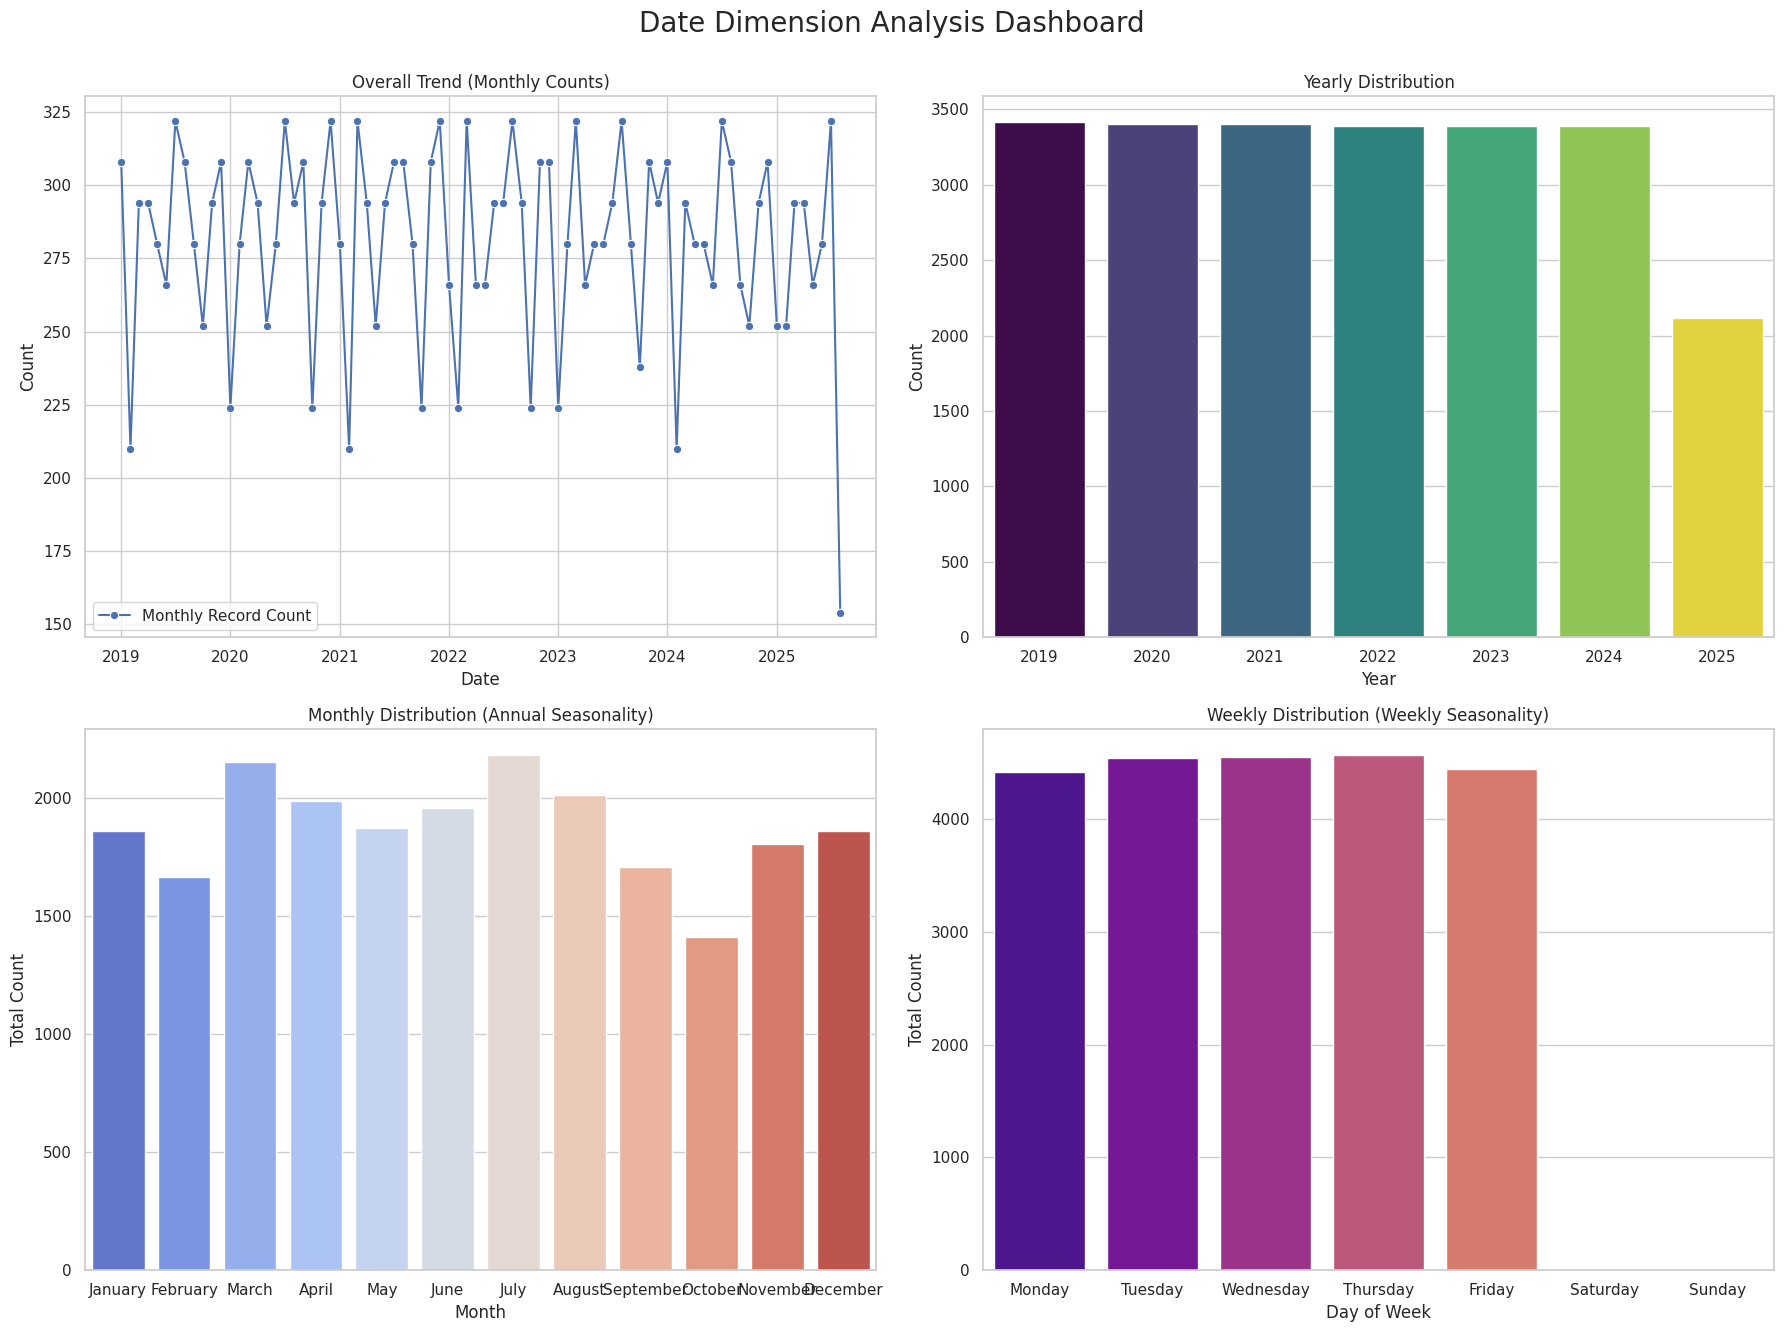


------------------------------
Annual Activity Calendar Heatmap


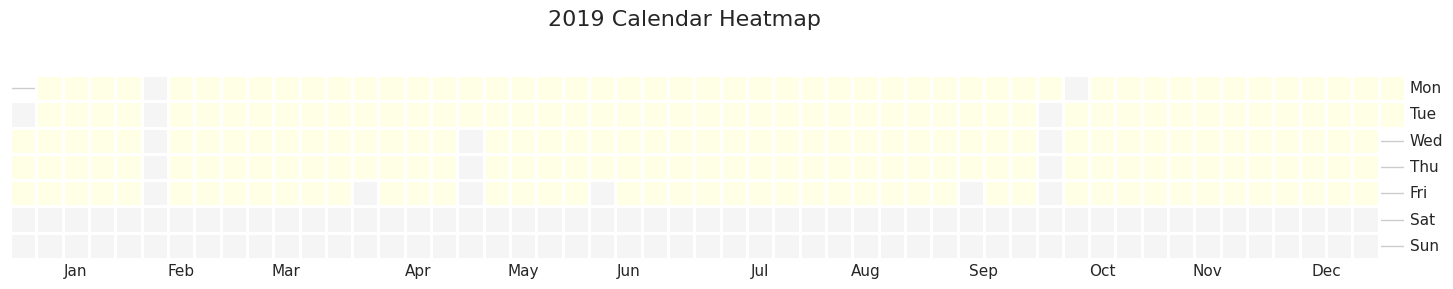

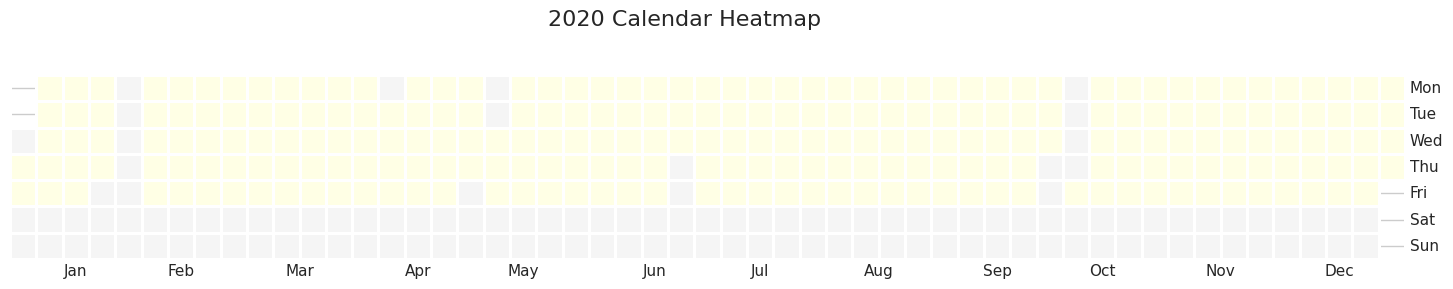

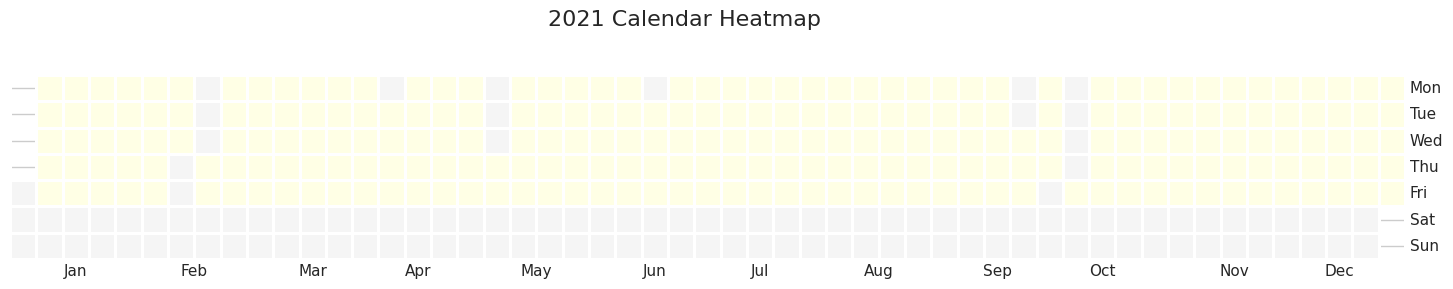

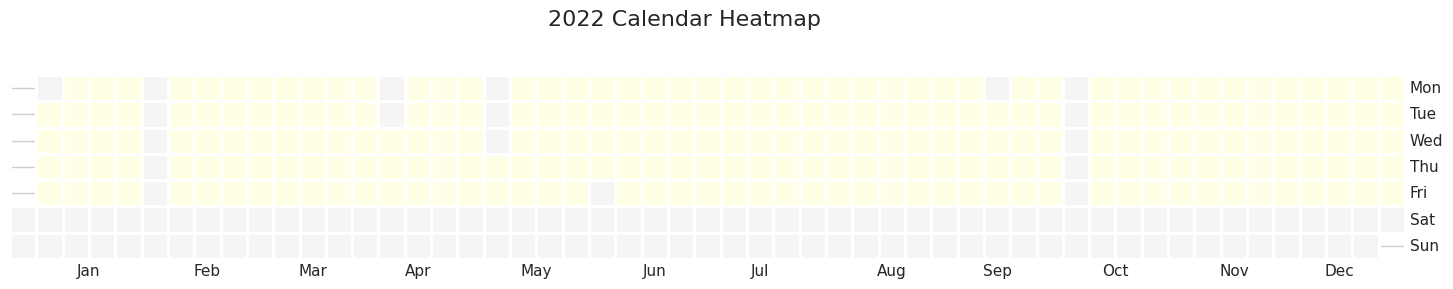

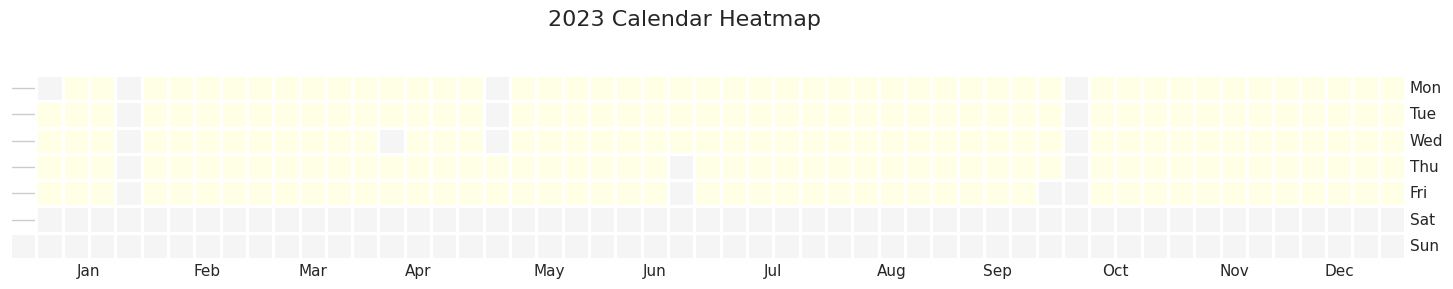

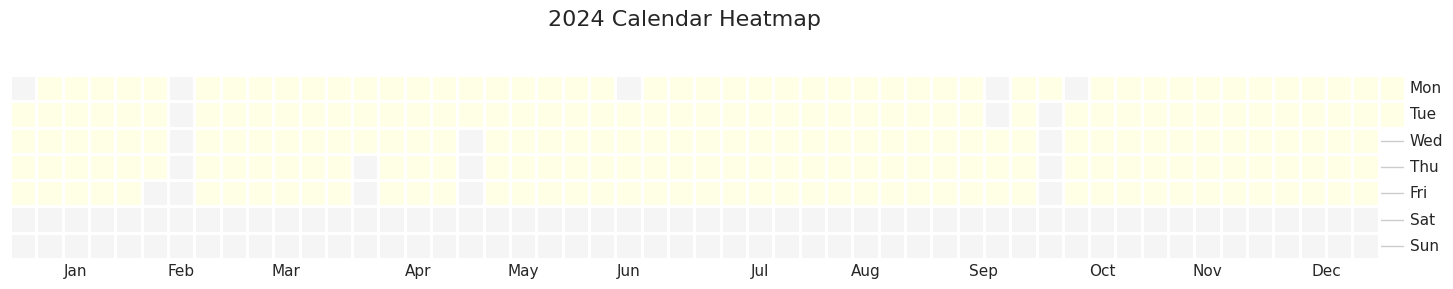

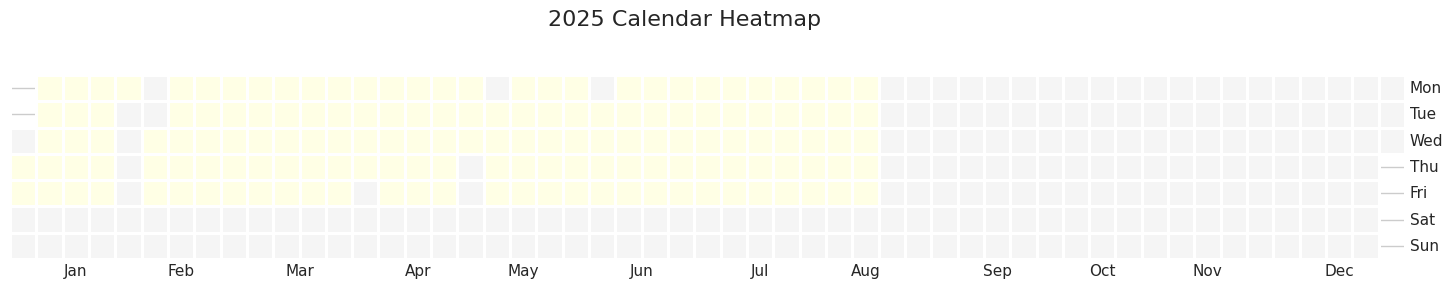

In [6]:
def eda_date_column(df, column_name=None):
    """
    column_name :
        要分析的日期列的名称。
        如果为None，函数会按以下顺序自动查找：
        1. 寻找名为 '日期' 的列。
        2. 使用第0列作为日期列。
    """
    
    # --- 1. 自动定位和预处理日期列 ---
    df_copy = df.copy()
    
    if column_name:
        if column_name not in df_copy.columns:
            print(f"错误：列 '{column_name}' 不存在于DataFrame中。")
            return
    else:
        if '日期' in df_copy.columns:
            column_name = '日期'
        else:
            column_name = df_copy.columns[0]
            print(f"提示：未指定列名，已自动选择第0列 '{column_name}' 进行分析。")

    try:
        # 转换为datetime对象，errors='coerce'会把无法转换的值设为NaT
        df_copy[column_name] = pd.to_datetime(df_copy[column_name], errors='coerce')
        # 移除转换后为空的行
        original_rows = len(df_copy)
        df_copy.dropna(subset=[column_name], inplace=True)
        if len(df_copy) < original_rows:
            print(f"提示：已移除 {original_rows - len(df_copy)} 个无法解析的日期行。")
    except Exception as e:
        print(f"错误：转换列 '{column_name}' 为日期时失败: {e}")
        return
        
    print(f"EDA for Date Column: '{column_name}'")
    print("-" * 30)
    min_date = df_copy[column_name].min().strftime('%Y-%m-%d')
    max_date = df_copy[column_name].max().strftime('%Y-%m-%d')
    print(f"时间范围: {min_date} to {max_date}")
    print(f"总记录数: {len(df_copy)}")
    
    # --- 2. 提取日期特征 ---
    s = df_copy[column_name]
    features = {
        '年份': s.dt.year,
        '月份': s.dt.month,
        '星期': s.dt.day_name(),
        '季度': s.dt.quarter,
        '周数': s.dt.isocalendar().week,
    }
    features_df = pd.DataFrame(features)
    
    # --- 3. 创建多维度可视化仪表盘 ---
    # 移除了 font='SimHei'
    sns.set_theme(style="whitegrid") 
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle(f"Date Dimension Analysis Dashboard", fontsize=20, y=0.95)
    
    # 图1: 按月统计的总体趋势
    monthly_counts = s.dt.to_period('M').value_counts().sort_index()
    monthly_counts.index = monthly_counts.index.to_timestamp()
    sns.lineplot(data=monthly_counts, ax=axes[0, 0], marker='o', label='Monthly Record Count')
    axes[0, 0].set_title('Overall Trend (Monthly Counts)')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Count')
    
    # 图2: 按年份分布
    sns.countplot(data=features_df, x='年份', hue='年份', legend=False, ax=axes[0, 1], palette='viridis')
    axes[0, 1].set_title('Yearly Distribution')
    axes[0, 1].set_xlabel('Year')
    axes[0, 1].set_ylabel('Count')
    
    # 图3: 按月份分布 (年度周期性)
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    month_counts = features_df['月份'].value_counts().sort_index()
    month_counts.index = month_counts.index.map(lambda x: pd.to_datetime(f'2000-{x}-01').strftime('%B'))
    month_counts = month_counts.reindex(month_order).fillna(0)

    sns.barplot(x=month_counts.index, hue=month_counts.index, legend=False, y=month_counts.values, ax=axes[1, 0], palette='coolwarm')
    axes[1, 0].set_title('Monthly Distribution (Annual Seasonality)')
    axes[1, 0].set_xlabel('Month')
    axes[1, 0].set_ylabel('Total Count')
    
    # 图4: 按星期分布 (周度周期性)
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    day_counts = features_df['星期'].value_counts().reindex(day_order)
    
    sns.barplot(x=day_counts.index, hue=day_counts.index, legend=False, y=day_counts.values, ax=axes[1, 1], palette='plasma')
    axes[1, 1].set_title('Weekly Distribution (Weekly Seasonality)')
    axes[1, 1].set_xlabel('Day of Week')
    axes[1, 1].set_ylabel('Total Count')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # --- 4. [优雅的可视化] 绘制日历热力图, 黄色说明有活动,灰色说明没这个日期 ---
    try:
        print("\n" + "-" * 30)
        print("Annual Activity Calendar Heatmap")
        daily_counts = s.dt.date.value_counts()
        daily_counts.index = pd.to_datetime(daily_counts.index)
        
        # 为每个年份绘制一张图
        for year in sorted(daily_counts.index.year.unique()):
            plt.figure(figsize=(18, 3))
            calmap.yearplot(daily_counts, year=year, cmap='YlGn')
            plt.suptitle(f'{year} Calendar Heatmap', fontsize=16, y=1.02)
            plt.show()
    except Exception as e:
        print(f"提示：无法绘制日历热力图，可能因为数据量或日期范围问题。错误: {e}")

eda_date_column(df)

# 相关性分析

In [7]:
def encode_FE(df, cols):
    for col in cols:
        vc = df[col].value_counts(dropna=True, normalize=True).to_dict()
        df[col] = df[col].map(vc)
        df[col] = df[col].astype('float32')
    return df

def analyze_correlation(df):
    """
    自动预处理DataFrame并分析列之间的相关性。

    过程:
    1. 复制原始DataFrame以避免修改。
    2. 自动检测并转换日期/时间类型的列 (包括字符串格式) 为Unix时间戳。
    3. 对剩余的字符串(分类)列进行频率编码。
    4. 计算处理后所有数值列的相关性矩阵。

    参数:
        df (pd.DataFrame): 需要分析的输入DataFrame。

    返回:
        tuple: 一个包含两个元素的元组:
            - (pd.DataFrame): 经过预处理的全数值DataFrame。
            - (pd.DataFrame): 计算出的相关性矩阵。
    """
    print("--- 启动分析流程 ---")
    df_processed = df.copy()

    # 步骤 1: 优先处理日期/时间类型的列
    # 这样可以避免日期字符串被错误地当作普通分类变量处理
    date_cols_found = []
    for col in df_processed.columns:
        # 只尝试转换非数值类型的列
        if df_processed[col].dtype == 'object' or pd.api.types.is_datetime64_any_dtype(df_processed[col].dtype):
            try:
                # 尝试将列转换为datetime格式，无法转换的值会变为NaT
                temp_dt = pd.to_datetime(df_processed[col], errors='coerce')
                
                # 如果转换后至少有一个有效日期，则认为该列是日期列
                if not temp_dt.isnull().all():
                    print(f"检测到日期/时间列: '{col}' -> 转换为Unix时间戳")
                    # 转换为以秒为单位的Unix时间戳
                    df_processed[col] = temp_dt.astype('int64') // 10**9
                    date_cols_found.append(col)
            except (ValueError, TypeError):
                # 如果转换失败，说明不是日期列，跳过
                continue
    
    # 步骤 2: 处理剩余的字符串 (分类) 列
    # 选择所有数据类型仍为 'object' 的列
    str_cols_to_encode = df_processed.select_dtypes(include=['object']).columns.tolist()

    if str_cols_to_encode:
        print(f"检测到字符/分类列: {str_cols_to_encode} -> 进行频率编码")
        df_processed = encode_FE(df_processed, str_cols_to_encode)
    else:
        print("未找到需要频率编码的字符/分类列。")

    # 步骤 3: 计算相关性矩阵
    # 确保所有列都是数值类型
    numeric_cols = df_processed.select_dtypes(include=np.number).columns.tolist()
    if len(numeric_cols) != len(df_processed.columns):
        print("\n警告: 并非所有列都能转换为数值类型。相关性将只在数值列上计算。")
    
    print("正在计算相关性矩阵...")
    correlation_matrix = df_processed[numeric_cols].corr()
    
    print("--- 分析流程结束 ---")
    return df_processed, correlation_matrix

df_processed_result, correlation_matrix_result = analyze_correlation(df)
print(correlation_matrix_result)

print("\n\n" + "="*50)
print("      各列的 Top 5 最高相关性分析")
print("="*50)

# 遍历相关性矩阵中的每一列
for column in correlation_matrix_result.columns:
    print(f"\n--- 与 '{column}' 相关性最高的 Top 5 列 ---")
    correlations = correlation_matrix_result[column].drop(column)
    
    # 2. 找到绝对值最高的5个相关性的索引 (列名)
    #    使用 .abs() 来确保强负相关也被认为是“高”相关性
    #    使用 .nlargest(5) 来高效获取前5个值
    top_5_indices = correlations.abs().nlargest(5).index
    
    # 3. 使用这些索引从原始的相关性级数中 (包含正负号) 获取并显示结果
    top_5_values = correlations.loc[top_5_indices]
    
    # 4. 检查是否有足够的相关列可供显示
    if top_5_values.empty:
        print("没有其他列可进行相关性比较。")
    else:
        print(top_5_values)


--- 启动分析流程 ---
检测到日期/时间列: '日期' -> 转换为Unix时间戳
检测到字符/分类列: ['证券代码'] -> 进行频率编码
正在计算相关性矩阵...
--- 分析流程结束 ---
            ID  证券代码        日期       开盘价       最高价       最低价       收盘价  \
ID    1.000000   NaN  0.071428  0.015681  0.011909  0.016013  0.015663   
证券代码       NaN   NaN       NaN       NaN       NaN       NaN       NaN   
日期    0.071428   NaN  1.000000  0.473793  0.467465  0.478101  0.472056   
开盘价   0.015681   NaN  0.473793  1.000000  0.994602  0.993744  0.992450   
最高价   0.011909   NaN  0.467465  0.994602  1.000000  0.996414  0.997536   
最低价   0.016013   NaN  0.478101  0.993744  0.996414  1.000000  0.998360   
收盘价   0.015663   NaN  0.472056  0.992450  0.997536  0.998360  1.000000   
结算价   0.009340   NaN  0.481747  0.992175  0.997480  0.998440  0.999763   
成交量  -0.281464   NaN  0.089439  0.081677  0.094927  0.068575  0.078410   
持仓量  -0.214358   NaN  0.020476  0.002842  0.012790 -0.002112  0.003318   

           结算价       成交量       持仓量  
ID    0.009340 -0.281464 -0.214358  
证券代码    

/tmp/ipykernel_3969999/326313969.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_dt = pd.to_datetime(df_processed[col], errors='coerce')
